# Project Description

Sweet Lift Taxi has collected historical data on taxi requests at airports. To attract more drivers during peak hours, we need to predict the number of taxi requests for the next hour. Build a model for this prediction.

The RECM metric on the test set should not exceed 48.

## Project instructions.

1. Download the data and resample for an hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 4. Test the data using the test sample and provide a conclusion.

## Data Description

The data is stored in the file `taxi.csv`.
The number of orders is in the `num_orders` column.

## Data Visualization

In [120]:
# Library are imported

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display

In [13]:
# Data is displayed

df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
display(df)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [15]:
# Relevant information is displayed

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [17]:
# Duplicates and their number are shown

print(df.duplicated().sum())
print(df.isnull().sum())

26415
num_orders    0
dtype: int64


In [18]:
# Metrics for numerical variables are shown

df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


**Observations**

1. It is observed that the column names are in a simple format, there are no null values ​​or duplicate rows, the order metrics have normal values.
2. The only parameter to change is the variable type of the datetime column, set it as an index and sort them ascendingly by time.

## Analysis

In [53]:
# Dataframe adjustment
df.sort_index(inplace=True)
df = df.resample('1h').sum()
display(df)
print(df.index.is_monotonic_increasing)
df.info()

,num_orders,year,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-01 01:00:00,85,2018,3,3,1,124.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-01 02:00:00,71,2018,3,3,2,85.0,124.0,0.0,0.0,0.0,0.0,0.0
2018-03-01 03:00:00,66,2018,3,3,3,71.0,85.0,124.0,0.0,0.0,0.0,0.0
2018-03-01 04:00:00,43,2018,3,3,4,66.0,71.0,85.0,124.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,4,19,207.0,217.0,197.0,116.0,133.0,166.0,173.3
2018-08-31 20:00:00,154,2018,8,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.6
2018-08-31 21:00:00,159,2018,8,4,21,154.0,136.0,207.0,217.0,197.0,116.0,162.9


True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   year          4416 non-null   int32  
 2   month         4416 non-null   int32  
 3   dayofweek     4416 non-null   int32  
 4   hour          4416 non-null   int32  
 5   lag_1         4416 non-null   float64
 6   lag_2         4416 non-null   float64
 7   lag_3         4416 non-null   float64
 8   lag_4         4416 non-null   float64
 9   lag_5         4416 non-null   float64
 10  lag_6         4416 non-null   float64
 11  rolling_mean  4416 non-null   float64
dtypes: float64(7), int32(4), int64(1)
memory usage: 379.5 KB


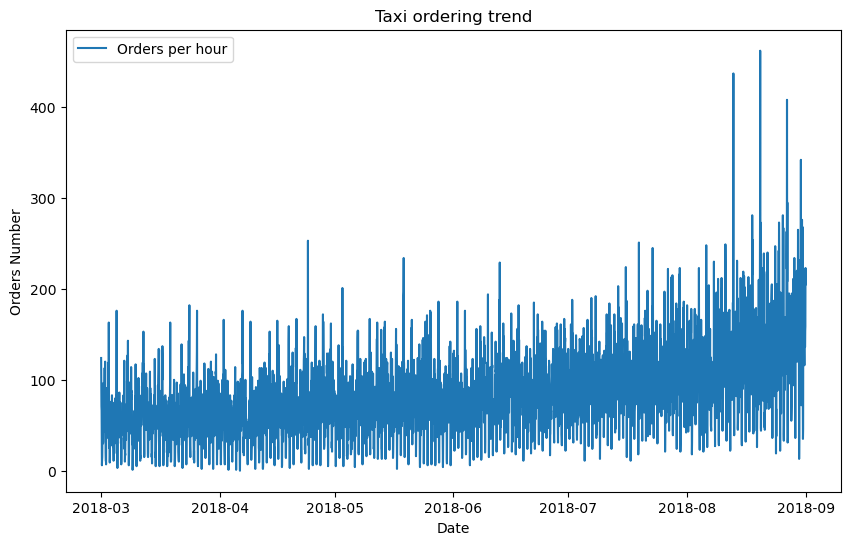

In [55]:
# Taxi ordering trend
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['num_orders'], label='Orders per hour')
plt.title('Taxi ordering trend')
plt.xlabel('Date')
plt.ylabel('Orders Number')
plt.legend()
plt.show()

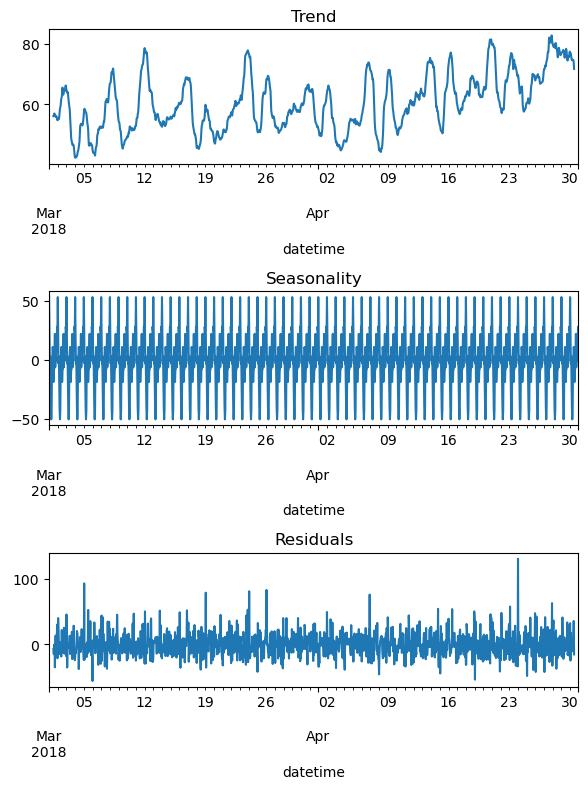

In [69]:
df_plt = df['2018-03':'2018-04'].resample('1h').sum()

decomposed = seasonal_decompose(df_plt['num_orders'], model='additive')

plt.figure(figsize=(6, 8))
plt.subplot(311)
# To display the chart correctly, specify its
# ax-axis equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

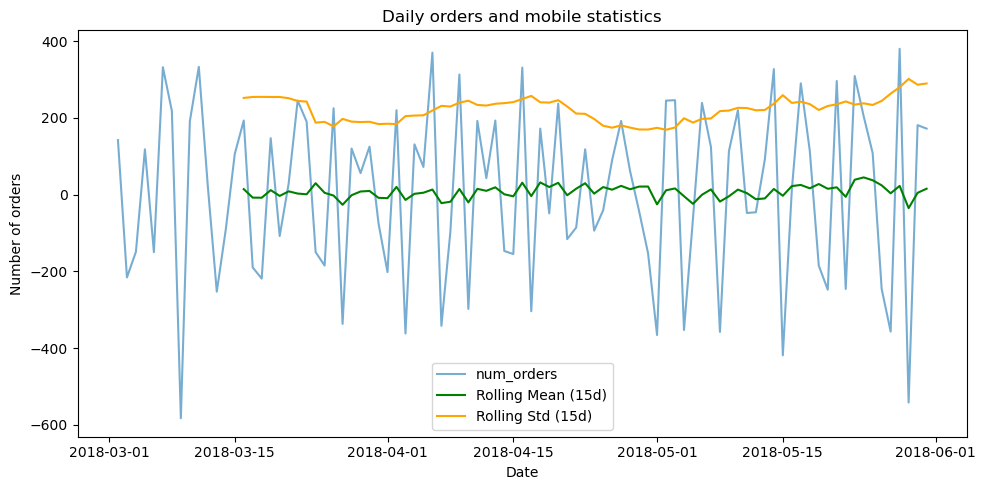

In [118]:
data = df['2018-03':'2018-05'].resample('1D').sum()
data['num_orders'] = data['num_orders'] - data['num_orders'].shift()

# Calculating moving mean and standard deviation
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()

# Plot only the desired columns
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['num_orders'], label='num_orders', alpha=0.6)
plt.plot(data.index, data['mean'], label='Rolling Mean (15d)', color='green')
plt.plot(data.index, data['std'], label='Rolling Std (15d)', color='orange')

plt.title('Daily orders and mobile statistics')
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.legend()
plt.tight_layout()
plt.show()

We can see from the graphs that it is a stochastic process since the distribution does not depend on time, it has a trend that can be seen when graphing a month and it has a season, this tells us that we can predict with this data.

## Models

In [83]:
# Function to create the features
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [85]:
# Division into training and testing
make_features(df, 6, 10)

df1 = df.dropna()
X = df1.drop(['num_orders'], axis = 1)
y = df1['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.1, random_state=12345)

In [87]:
# Model 1
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
pred_train = model_lr.predict(X_train)
rmse_lr = np.sqrt(mean_squared_error(y_train, pred_train))

print("\nModel: Linear Regression")
print(f"RECM: {rmse_lr:.2f}")


Model: Linear Regression
RECM: 30.63


In [89]:
# XGB Regressor model 4
# Model configuration
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.2,
    'max_depth': 5,
    'n_estimators': 50,
}

xgb_model = XGBRegressor(**params)
xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict(X_train)

rmse_xgb = np.sqrt(mean_squared_error(y_train, pred_xgb))

print("\nModel: XGBRegressor")
print(f"RECM: {rmse_xgb:.2f}")


Model: XGBRegressor
RECM: 15.92


In [93]:
# LightGBM model 5 

# Model configuration
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 10,
    'n_estimators': 100,
}

lgb_model = lgb.LGBMRegressor(**params)
lgb_model.fit(X_train, y_train)

# Prediction and evaluation
y_pred_lgbm = lgb_model.predict(X_train)
rmse_lgbm = mean_squared_error(y_train, y_pred_lgbm)
rmse_lgbm = np.sqrt(rmse_lgbm)

print("\nModel: LightGBM")
print(f"RECM: {rmse_lgbm:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 3965, number of used features: 10
[LightGBM] [Info] Start training from score 78.361665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

## Test


In [96]:
# Model 1

pred_test = model_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_test))
scores = cross_val_score(model_lr, X_test, y_test, cv=5)

print(f"RECM: {rmse_lr:.2f}")
print(f"\nModel: Linear Regression)")
print("CV:", scores.mean())

RECM: 53.90

Model: Linear Regression)
CV: 0.1617756736662486


In [101]:
# Desicion Tree Model 2
max_depth_values = [5, 10, 15, 20]

for depth in max_depth_values:
    dt_model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    dt_model.fit(X_train, y_train)

    # Prediction and evaluation
    y_pred_dt = dt_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred_dt)
    rmse = np.sqrt(rmse)
    
    scores = cross_val_score(dt_model, X_test, y_test, cv=5)

    print(f"\nModel: Decision Tree (max_depth={depth})")
    print(f"RECM: {rmse:.2f}")
    print("CV:", scores.mean())


Model: Decision Tree (max_depth=5)
RECM: 56.69
CV: 0.4260202387449604

Model: Decision Tree (max_depth=10)
RECM: 47.69
CV: 0.24418753441222946

Model: Decision Tree (max_depth=15)
RECM: 53.16
CV: 0.21725477660954837

Model: Decision Tree (max_depth=20)
RECM: 59.97
CV: 0.17692886003075373


In [103]:
# Random Forest Model 3

# Hyperparameters to tune
n_estimators_values = [50, 75, 100]
max_depth_values=[5, 10, 15]

for estimators in n_estimators_values:
    for max_depth in max_depth_values:
        rf_model = RandomForestRegressor(n_estimators=estimators, max_depth=max_depth, random_state=12345)
        rf_model.fit(X_train, y_train)

        # Prediction and evaluation
        y_pred = rf_model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(rmse)
        scores = cross_val_score(rf_model, X_test, y_test, cv=5)

        print(f"\nModel: Random Forest (n_estimators={estimators} y max_depth={max_depth})")
        print(f"RECM: {rmse:.2f}")
        print("CV:", scores.mean())
    del rf_model, rmse, y_pred


Model: Random Forest (n_estimators=50 y max_depth=5)
RECM: 54.61
CV: 0.49252721573139996

Model: Random Forest (n_estimators=50 y max_depth=10)
RECM: 47.54
CV: 0.5032692948423966

Model: Random Forest (n_estimators=50 y max_depth=15)
RECM: 45.98
CV: 0.4988002298065206

Model: Random Forest (n_estimators=75 y max_depth=5)
RECM: 54.39
CV: 0.4852938537023312

Model: Random Forest (n_estimators=75 y max_depth=10)
RECM: 47.28
CV: 0.4985505885420836

Model: Random Forest (n_estimators=75 y max_depth=15)
RECM: 45.78
CV: 0.4976079073098429

Model: Random Forest (n_estimators=100 y max_depth=5)
RECM: 54.34
CV: 0.4910457655668095

Model: Random Forest (n_estimators=100 y max_depth=10)
RECM: 46.84
CV: 0.5063077769282994

Model: Random Forest (n_estimators=100 y max_depth=15)
RECM: 45.31
CV: 0.5038225781400781


In [106]:
# XGB Regressor model 4

# Prediction and evaluation
pred_xgb = xgb_model.predict(X_test)
rmse_xgb = mean_squared_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(rmse_xgb)
scores = cross_val_score(xgb_model, X_test, y_test, cv=5)

print("\nModel: XGBoost")
print(f"RECM: {rmse_xgb:.2f}")
print("CV:", scores.mean())


Model: XGBoost
RECM: 47.20
CV: 0.47480628490447996


In [110]:
# LightGBM model 5 
# Prediction and evaluation
y_pred_lgbm = lgb_model.predict(X_test)
rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(rmse_lgbm)
scores = cross_val_score(lgb_model, X_test, y_test, cv=5)

print("\nModel: LightGBM")
print(f"RECM: {rmse_lgbm:.2f}")
print("CV:", scores.mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 352, number of used features: 9
[LightGBM] [Info] Start training from score 143.250000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

## Conclusion

1. The model that showed the best performance was LightGBM with the lowest error in cross-validation and the lowest error by RECM.
2. In general terms, the Random Forest algorithm also showed a good performance, improving the required error value; however, it turns out to be slower than LightGBM
3. It can predict to a good extent the days in which there will be more taxi orders